In [1]:
!git clone https://github.com/muxspace/facial_expressions.git

Cloning into 'facial_expressions'...
remote: Enumerating objects: 14214, done.
remote: Total 14214 (delta 0), reused 0 (delta 0), pack-reused 14214
Receiving objects: 100% (14214/14214), 239.65 MiB | 41.60 MiB/s, done.
Resolving deltas: 100% (223/223), done.
Checking out files: 100% (13996/13996), done.


In [2]:
import csv
# We will store data in a dictionary
data = {}

In [3]:
with open("/content/facial_expressions/data/legend.csv") as file:
  csv_reader = csv.reader(file)
  next(csv_reader)
  for row in csv_reader:
    ## refer the csv file
    key = row[2].lower() 
    if key  in data:
      data[key].append(row[1])
    else:
      data[key] = [row[1]]  


In [4]:
emotions = list(data.keys())
emotions

['anger',
 'surprise',
 'disgust',
 'fear',
 'neutral',
 'happiness',
 'sadness',
 'contempt']

In [5]:
import os
os.mkdir('Master_Date')
os.mkdir('Master_Date/training')
os.mkdir('Master_Date/testing')

In [6]:
for em in emotions:
  os.mkdir(os.path.join('Master_Date/training', em))
  os.mkdir(os.path.join('Master_Date/testing', em))

In [7]:
from shutil import copyfile
split_size = 0.8

for emotion, images in data.items():
  train_size = int(split_size * len(images)) 
  train_images = images[:train_size]
  test_images = images[train_size:]

  for image in train_images:
    src = os.path.join('/content/facial_expressions/images',image)
    dest = os.path.join('/content/Master_Date/training',emotion,image)
    copyfile(src,dest)
  for image in test_images:
    src = os.path.join('/content/facial_expressions/images',image)
    dest = os.path.join('/content/Master_Date/testing',emotion,image)
    copyfile(src,dest)

In [8]:
import tensorflow as tf


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train = '/content/Master_Date/training'
test = '/content/Master_Date/testing'

In [11]:
training_generator = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    vertical_flip = True,
    horizontal_flip = True
)

training_data = training_generator.flow_from_directory(
    train,
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = 32
)

testing_generator = ImageDataGenerator(rescale = 1.0/255)

testing_data = testing_generator.flow_from_directory(
    test,
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = 32
)

Found 10941 images belonging to 8 classes.
Found 2742 images belonging to 8 classes.


In [12]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-01-11 17:38:16--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   217MB/s    in 0.4s    

2023-01-11 17:38:16 (217 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [13]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [14]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()  

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

We will take upto mixed7 

In [15]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [16]:
last_output

<KerasTensor: shape=(None, 7, 7, 768) dtype=float32 (created by layer 'mixed7')>

In [17]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [23]:
def create_final_model(pre_trained_model, last_output):
  
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  ### START CODE HERE

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation = 'relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)  
  # Add a final sigmoid layer for classification
  x = layers.Dense(8, activation = 'softmax')(x)       

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = 'adam', 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  ### END CODE HERE
  
  return model

In [24]:
model = create_final_model(pre_trained_model,last_output)

In [37]:
def MyNeuralNetwork():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(128,(3,3), activation = 'relu', input_shape = (150,150,3) , padding = 'same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(3,3), activation = 'relu' , padding = 'valid'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      # Adding Dense layer
      tf.keras.layers.Dense(1024,activation = 'relu'),
      tf.keras.layers.Dropout(0.15),
      tf.keras.layers.Dense(512, activation = 'relu'),
      tf.keras.layers.Dense(8, activation = 'softmax')
  ])

  model.compile(
      loss = 'categorical_crossentropy',
      optimizer = 'RMSprop',
      metrics = ['accuracy']
  )

  return model

In [38]:
class MyCallBacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('accuracy') > 0.95:
      self.model.stop_training = True

In [39]:
model = MyNeuralNetwork()

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          (None, 150, 150, 128)     3584      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 75, 75, 128)      0         
 2D)                                                             
                                                                 
 conv2d_98 (Conv2D)          (None, 73, 73, 64)        73792     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_99 (Conv2D)          (None, 36, 36, 32)        18464     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 18, 18, 32)      

In [41]:
callback = MyCallBacks()
history = model.fit(
    training_data,
    validation_data = testing_data,
    batch_size = 32,
    epochs = 10,
    callbacks = [callback]
)

Epoch 1/10
342/342 [==============================] - 75s 212ms/step - loss: 1.0877 - accuracy: 0.4799 - val_loss: 1.4655 - val_accuracy: 0.3567
Epoch 2/10
342/342 [==============================] - 72s 209ms/step - loss: 1.0100 - accuracy: 0.4915 - val_loss: 1.6452 - val_accuracy: 0.4763
Epoch 3/10
342/342 [==============================] - 73s 214ms/step - loss: 1.0313 - accuracy: 0.5002 - val_loss: 1.2702 - val_accuracy: 0.3206
Epoch 4/10
342/342 [==============================] - 71s 209ms/step - loss: 1.0036 - accuracy: 0.5030 - val_loss: 1.9729 - val_accuracy: 0.4767
Epoch 5/10
342/342 [==============================] - 73s 215ms/step - loss: 1.0034 - accuracy: 0.5032 - val_loss: 2.5236 - val_accuracy: 0.4785
Epoch 6/10
342/342 [==============================] - 72s 210ms/step - loss: 1.0092 - accuracy: 0.5032 - val_loss: 1.1511 - val_accuracy: 0.4778
Epoch 7/10
342/342 [==============================] - 73s 214ms/step - loss: 0.9991 - accuracy: 0.5084 - val_loss: 2.0034 - val_ac

In [25]:
history =  model.fit(
    training_data,
    validation_data = testing_data,
    batch_size = 32,
    epochs = 10
)

Epoch 1/10
342/342 [==============================] - 77s 217ms/step - loss: 1.2083 - accuracy: 0.6556 - val_loss: 1.0683 - val_accuracy: 0.6163
Epoch 2/10
342/342 [==============================] - 72s 211ms/step - loss: 0.7490 - accuracy: 0.7171 - val_loss: 1.1805 - val_accuracy: 0.6495
Epoch 3/10
342/342 [==============================] - 74s 215ms/step - loss: 0.7230 - accuracy: 0.7288 - val_loss: 1.2704 - val_accuracy: 0.6379
Epoch 4/10
342/342 [==============================] - 89s 260ms/step - loss: 0.7146 - accuracy: 0.7362 - val_loss: 1.5319 - val_accuracy: 0.6090
Epoch 5/10
342/342 [==============================] - 80s 233ms/step - loss: 0.6968 - accuracy: 0.7394 - val_loss: 1.6518 - val_accuracy: 0.6397
Epoch 6/10
342/342 [==============================] - 83s 242ms/step - loss: 0.6837 - accuracy: 0.7465 - val_loss: 1.5399 - val_accuracy: 0.6513
Epoch 7/10
342/342 [==============================] - 79s 231ms/step - loss: 0.6763 - accuracy: 0.7512 - val_loss: 1.6242 - val_ac

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

In [28]:
import matplotlib.pyplot as plt

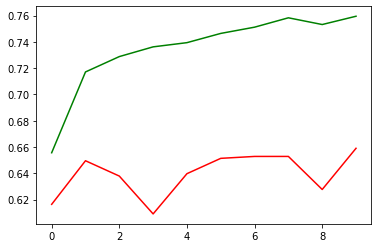

In [29]:
plt.plot(epochs,acc,'g',label = 'Training_Accuracy')
plt.plot(epochs,val_acc,'r',label = 'Testing Accuracy')
plt.show();